In [16]:

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [17]:

# Load data
df = pd.read_csv('model_data.csv')

# Clean up columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
df['side'] = df['side'].map({'SELL': 0, 'BUY': 1})
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df['price'] = pd.to_numeric(df['price'])
df = df.sort_values('time').reset_index(drop=True)

# Downsample to 1-minute intervals (every 4th row)
df = df.iloc[::4].reset_index(drop=True)


In [18]:

# Add volatility and relative features
df['volatility_50'] = df['price'].pct_change().rolling(window=50).std()
df['volatility_200'] = df['price'].pct_change().rolling(window=200).std()
df['relative_price'] = df['price'] / df['price'].rolling(window=50).mean() - 1
df['momentum_50'] = df['price'].pct_change() - df['price'].pct_change().shift(50)
df.dropna(subset=['volatility_50', 'volatility_200', 'relative_price', 'momentum_50'], inplace=True)

# Create future price change classification label (30 steps out)
forecast_horizon = 10
future_returns = (df['price'].shift(-forecast_horizon) / df['price'] - 1)

# Label: 1 = up (>0.1%), -1 = down (<-0.1%), 0 = flat in between
df['label'] = future_returns.apply(lambda x: 1 if x > 0.001 else (-1 if x < -0.001 else 0))

# Drop last rows where future return was not calculable
df = df.dropna(subset=['label']).reset_index(drop=True)


In [19]:

sequence_length = 20

X = []
y = []

features = df['price'].values
labels = df['label'].values
prices = df['price'].values

for i in range(len(features) - sequence_length):
    #X.append(features[i:i+sequence_length])
    X.append(prices[i:i+sequence_length])
    y.append(labels[i+sequence_length])

X, y = np.array(X), np.array(y)
y_categorical = to_categorical(y + 1, num_classes=3)  # Shift by +1 for indexing (labels are -1, 0, 1)


In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_categorical[:train_size], y_categorical[train_size:]

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(64, return_sequences=False),
    Dropout(0.4),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 94s 45ms/step - accuracy: 0.7027 - loss: 0.8226 - val_accuracy: 0.5722 - val_loss: 1.0138
Epoch 2/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 108s 52ms/step - accuracy: 0.7047 - loss: 0.8147 - val_accuracy: 0.5722 - val_loss: 1.0197
Epoch 3/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 102s 50ms/step - accuracy: 0.7058 - loss: 0.8115 - val_accuracy: 0.5722 - val_loss: 1.0129
Epoch 4/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 107s 52ms/step - accuracy: 0.7052 - loss: 0.8117 - val_accuracy: 0.5722 - val_loss: 1.0243
Epoch 5/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 89s 43ms/step - accuracy: 0.7056 - loss: 0.8110 - val_accuracy: 0.5722 - val_loss: 1.0138
Epoch 6/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 96s 46ms/step - accuracy: 0.7057 - loss: 0.8104 - val_accuracy: 0.5722 - val_loss: 1.0201
Epoch 7/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 1060s 515ms/step - accuracy: 0.7041 - loss: 0.8127 - val_accuracy: 0.5722 - val_loss: 1.0224
Epoch 8/50
2060/2060 ━━━━━━━━━━━━━━━━━━━━ 7413s 4s/step - accuracy: 0.

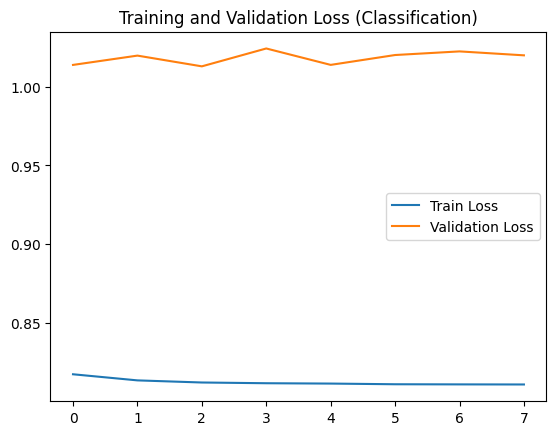

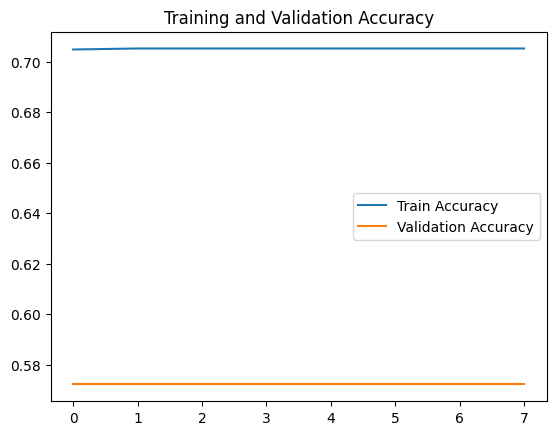

In [21]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Classification)')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


2060/2060 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     14207
           0       0.57      1.00      0.73     37707
           1       0.00      0.00      0.00     13986

    accuracy                           0.57     65900
   macro avg       0.19      0.33      0.24     65900
weighted avg       0.33      0.57      0.42     65900



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

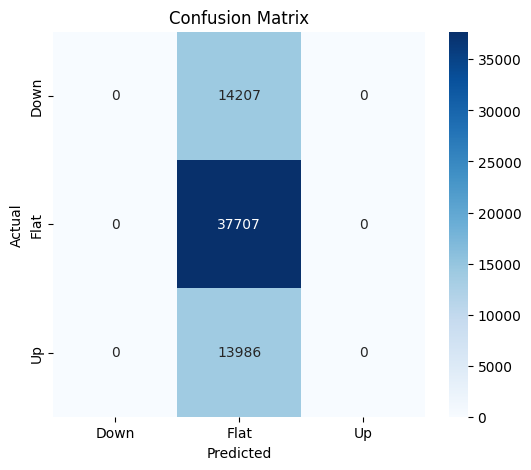

In [22]:

from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) - 1  # shift back to -1,0,1
y_true_classes = np.argmax(y_test, axis=1) - 1

print(classification_report(y_true_classes, y_pred_classes))
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down','Flat','Up'], yticklabels=['Down','Flat','Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
